In [ ]:
!pip install -U torchtext==0.8.0

In [ ]:
import pandas as pd
import re
import gensim
from nltk.corpus import stopwords
import nltk

# load stopwords
nltk.download('stopwords')
en_stopwords = stopwords.words('english')
additional_stosp = ["hello", "doctor", "january", "february", "march", "april", 
                   "may", "june", "july", "august", "september", "october", "november", "december",
                   "hi", "would", "also", "yes", "no", "please", "hello", "thank", "thanks", "regards"]
stops = additional_stop + en_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
def average_length(path):
  material = open(path, 'r').read().splitlines()
  output = []
  length = 0
  tt = []
  for sent in material:
    temp = sent.split()
    length += len(temp)
    tt.append(len(temp))
    output.append(temp)
  return length/len(material), material, tt

In [ ]:
avg_len_COPD_train2, clean_COPD_train2, lengths1 = average_length("clean_COPD_train2.txt")
print(avg_len_COPD_train2)

avg_len_pneumonia, clean_pneumonia, lengths3 = average_length("clean_pneumonia2.txt")
print(avg_len_pneumonia)

In [ ]:
print("Dataset size:")
print("COPD_train: %d" % (len(clean_COPD_train2)))
print("pneumonia: %d" % (len(clean_pneumonia)))

Dataset size:
COPD_train: 6219
pneumonia: 1401


(array([603., 450., 238.,  70.,  20.,   7.,   6.,   3.,   2.,   2.]),
 array([  4. ,  18.6,  33.2,  47.8,  62.4,  77. ,  91.6, 106.2, 120.8,
        135.4, 150. ]),
 <a list of 10 Patch objects>)

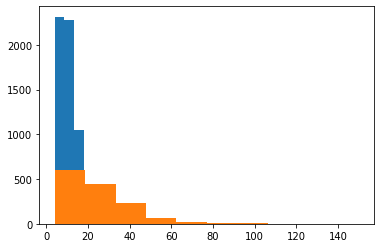

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lengths1)
plt.hist(lengths3)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

text_train = clean_COPD_train2 + clean_pneumonia
labels = np.concatenate((np.ones(len(clean_COPD_train2), dtype=np.int32), np.zeros(len(clean_pneumonia), dtype=np.int32))).reshape(-1)
len(text_train)

7620

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, fbeta_score

X_train, X_test, y_train, y_test = train_test_split(text_train, labels, test_size=0.2, train_size=0.8, random_state=30, shuffle=True)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# create training and testing data frames
dict1 = {'label': y_train, 'text': X_train}
dict2 = {'label': y_test, 'text': X_test}
       
df1 = pd.DataFrame(dict1) 
df2 = pd.DataFrame(dict2) 

df1.to_csv("train.csv", index=False)
df2.to_csv("test.csv", index=False)

In [ ]:
from torchtext.data import Field, TabularDataset, BucketIterator
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, test = TabularDataset.splits(path="./", train='train.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

class LSTM(nn.Module):
  
  def __init__(self, dimension=25):
    super(LSTM, self).__init__()

    self.embedding = nn.Embedding(len(text_field.vocab), 300)
    self.dimension = dimension
    self.lstm = nn.LSTM(input_size=300,
                        hidden_size=dimension,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=True)
    self.drop = nn.Dropout(p=0.5)

    self.fc = nn.Linear(2*dimension, 1)

  def forward(self, text, text_len):
    text_emb = self.embedding(text)

    packed_input = pack_padded_sequence(text_emb, text_len.to('cpu'), batch_first=True, enforce_sorted=False)
    packed_output, _ = self.lstm(packed_input)
    output, _ = pad_packed_sequence(packed_output, batch_first=True)

    out_forward = output[range(len(output)), text_len - 1, :self.dimension]
    out_reverse = output[:, 0, self.dimension:]
    out_reduced = torch.cat((out_forward, out_reverse), 1)
    text_fea = self.drop(out_reduced)

    text_fea = self.fc(text_fea)
    text_fea = torch.squeeze(text_fea, 1)
    text_out = torch.sigmoid(text_fea)

    return text_out

In [ ]:
def save_metrics(save_path, train_loss_list, global_steps_list):

    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "./"):
  
  running_loss = 0.0
  global_step = 0

  model.train()
  for epoch in range(num_epochs):
    for (labels, (text, text_len), ), _ in train_loader:
      labels = labels.to(device)
      titletext = text.to(device)
      titletext_len = text_len.to(device)
      output = model(titletext, titletext_len)

      loss = criterion(output, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      global_step += 1

      if global_step % eval_every == 0:
        average_train_loss = running_loss / eval_every
        running_loss = 0.0

Model loaded from <== ./metrics.pt


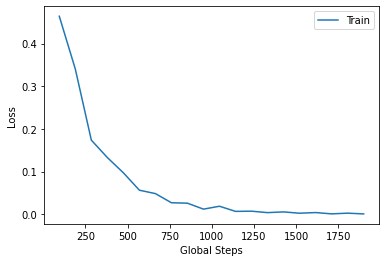

In [ ]:
train_loss_list, global_steps_list = load_metrics('./metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):
  
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for (labels, (text, text_len)), _ in test_loader:
      labels = labels.to(device)
      titletext = text.to(device)
      titletext_len = text_len.to(device)
      output = model(titletext, titletext_len)

      output = (output > threshold).int()
      y_pred.extend(output.tolist())
      y_true.extend(labels.tolist())
  
  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
  return fbeta_score(y_true, y_pred, beta=0.7, labels=[1,0])

In [ ]:
# train the model
model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model=model, optimizer=optimizer, num_epochs=10)

In [ ]:
# evaluate the model
best_model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(model, test_iter)